In [1]:
# processing
import pymysql.cursors
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scikitplot as skplt
from pandas import ExcelWriter
scaler = StandardScaler()
label = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
%matplotlib inline
# vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.externals.six import StringIO
import pydot
# model
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score, train_test_split, KFold 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report
# classificators
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib
import IDF
from sklearn.calibration import CalibratedClassifierCV
import lightgbm
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.decomposition import PCA

In [2]:
# Подключиться к базе данных
def con():
    conn = pymysql.connect(
        host='10.100.0.100',
        port=33062,
        user='i.serov',
        password='7*&y9EkL',
        db='mysql')
    return conn

In [335]:
%%time
df = pd.read_sql('''
SELECT
    c.date_requested,
    day(c.date_requested)                                                                               AS day_date_req,
    c.id                                                                                                AS credit_id,
    (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15,
    round(datediff(c.date_requested, pd.birthday) / 365)                                                AS age,
    pd.dependants_count,
    pd.maritalStatus_old,
    pd.maritalStatus,
    pd.sex,
    pd.habitation_old,
    pd.habitation,
    pd.payments_loans,
    pd.payments_loans_currency,
    pd.credit_purpose_id,
    a.city,
    if(ua.blocked IS TRUE, 1, 0)                                                                        AS blocked,
    if(ua.change_password_on_login IS TRUE, 1,0)                                                        AS change_password_on_login,
    if(ua.deleted IS TRUE, 1, 0)                                                                        AS deleted,
    datediff(c.date_requested, ua.creation_date)                                                        AS days_after_reg,

    w.amount,
    w.education,
    w.job_time,
    ifnull(abs(datediff(w.next_income_date, c.date_requested)), -1)                                     AS days_bef_sal,
    ifnull(abs((day(w.next_income_date) - day(c.date_requested))), -1)                                  AS days_bef_sal_days,
    w.employment_id,
    w.industry_id,

    if(b.is_filled_idv IS TRUE, 1, 0)                                                                                               AS is_filled_idv,
    if(b.is_reset_bank_account IS TRUE, 1, 0)                                                                                        AS is_reset_bank_account,
    if(b.has_online_banking IS TRUE, 1, 0)                                                                                            AS has_online_banking,
    #iud.*,
    ineg.*,
    ipos.*,
    inm.*,
    ipm.*,
    fs.FRAUD_SCORING_SAS,
    if(d.registered_flag IS TRUE, 1, 0)                                                                                               AS registered_flag,
    if(d.original_equals_aeat_flag IS TRUE, 1, 0)                                                                                     AS original_equals_aeat_flag
FROM moneyman_es.credit c
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.personal_data pd
        ON b.personal_data_id = pd.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.address a
        ON b.address_id = a.id
    LEFT JOIN moneyman_es.user_account ua
        ON b.user_account_id = ua.id
    LEFT JOIN moneyman_es.credit_risk_filter crf
        ON c.id = crf.credit_id
    left join moneyman_es.instantor_agg_negative_total ineg
on ineg.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_total ipos
on ipos.credit_id=crf.credit_id

#left join moneyman_es.instantor_user_details iud
#on iud.id=crf.instantor_user_details_id

left join moneyman_es.instantor_agg_negative_microlenders inm
on inm.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_microlenders ipm
on ipm.credit_id=crf.credit_id    
left join rnd.fs_new_inst_res fs
    on fs.id=c.id
LEFT JOIN moneyman_es.deyde_passport_response d
        ON c.id = d.credit_id
WHERE crf.instantor_user_details_id is not null and
    c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED') AND credit_number = 1 AND c.date_requested > '2017-07-01' AND
    c.date_requested < '2018-01-01'
    #and c.finance_type = 'PERIODIC';
''', con=con())
df.fillna(-1, inplace=True)
#df.balance = df.balance.map(lambda x: float(x))
#df.device_new = df.device_new.map(lambda x: float(x))
df1 = df.copy()

Wall time: 8.53 s


In [ ]:
%%time
inst_only = pd.read_sql('''
SELECT
    c.date_requested,
    day(c.date_requested)                                                                               AS day_date_req,
    c.id                                                                                                AS credit_id,
    (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15,
         ineg.*,
    ipos.*,
    inm.*,
    ipm.*,
    if(d.registered_flag IS TRUE, 1, 0)                                                                                               AS registered_flag,
    if(d.original_equals_aeat_flag IS TRUE, 1, 0)                                                                                     AS original_equals_aeat_flag
FROM moneyman_es.credit c
        LEFT JOIN moneyman_es.credit_risk_filter crf
        ON c.id = crf.credit_id
    left join moneyman_es.instantor_agg_negative_total ineg
on ineg.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_total ipos
on ipos.credit_id=crf.credit_id

#left join moneyman_es.instantor_user_details iud
#on iud.id=crf.instantor_user_details_id

left join moneyman_es.instantor_agg_negative_microlenders inm
on inm.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_microlenders ipm
on ipm.credit_id=crf.credit_id    
LEFT JOIN moneyman_es.deyde_passport_response d
        ON c.id = d.credit_id
WHERE crf.instantor_user_details_id is not null and
    c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED', 'SOLD') AND credit_number = 1 AND c.date_requested > '2017-09-01' AND
    c.date_requested < '2018-03-01';
''', con=con())
#inst_only.balance = inst_only.balance.map(lambda x: float(x))
df = inst_only.copy()
df.fillna(-1, inplace=True)

In [225]:
#X.dtypes[(X.dtypes!=object) & (X.dtypes!=int) & (X.dtypes!=float)]
#X.dtypes[X.dtypes==object]

In [322]:
df.dtypes[df.dtypes==object]

iov_gadget_type                             object
iov_if_alias_new_f_client_and_iovationDB    object
dtype: object

In [336]:
df.NPL15.value_counts()

0    9078
1    2505
Name: NPL15, dtype: int64

# Preprocessing

#### Df preprocessing

In [337]:
df.drop(['date_requested', 'credit_id', 'id', #'email', 'phone', 'address', 'user_name', 'instantor_id', 'borrower_id','national_id', 
         'instantor_user_details_id',  'number', 'kind', 'currency', 'iban', 'account_number', 'holder_name','credit_request_id' 
         ], axis=1, inplace=True)

In [340]:
cat_vars = ['habitation', 'habitation_old', 'maritalStatus', 'city'
           #new
           #'iov_gadget_type','iov_if_alias_new_f_client_and_iovationDB'
           ]
for i in cat_vars:
    df[i] = label.fit_transform(df[i].astype(str))

# Model

In [341]:
y = df.NPL15
X = df.drop(['NPL15'], axis=1)

In [342]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [343]:
clf = GradientBoostingClassifier()

In [344]:
%%time
tuned_parameters = {'n_estimators': [100,120,140]
                    #,'max_depth': [3,5]
                    }                    #'learning_rate': [0.1, 0.01] 
gs = GridSearchCV(clf, tuned_parameters, cv=3, verbose=2).fit(X_train, y_train)
print (gs.best_estimator_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=100 ................................................
[CV] ....................................... n_estimators=100 -   7.6s
[CV] n_estimators=100 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ....................................... n_estimators=100 -   7.8s
[CV] n_estimators=100 ................................................
[CV] ....................................... n_estimators=100 -   7.1s
[CV] n_estimators=120 ................................................
[CV] ....................................... n_estimators=120 -   8.7s
[CV] n_estimators=120 ................................................
[CV] ....................................... n_estimators=120 -   8.6s
[CV] n_estimators=120 ................................................
[CV] ....................................... n_estimators=120 -   8.4s
[CV] n_estimators=140 ................................................
[CV] ....................................... n_estimators=140 -  10.1s
[CV] n_estimators=140 ................................................
[CV] ....................................... n_estimators=140 -   9.8s
[CV] n_estimators=140 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
Wall time: 1min 30s


In [ ]:
#%%time
#clf = xgb.XGBClassifier(n_estimators=500, learning_rate = 0.05, verbose=False).fit(X_train, y_train)

# Score and Graphs

ROC_AUC:   0.6886016451233844
Gini:      0.3772032902467688
F1_score:  0.09431939978563773
Log_loss:  7.634297077061245


Classification_report: 
              precision    recall  f1-score   support

          0       0.99      0.78      0.87      3749
          1       0.05      0.59      0.09        74

avg / total       0.97      0.78      0.86      3823



Weight,Feature
0.0327 ± 0.1969,microlenders_amount_M1
0.0305 ± 0.1570,supermarket_amount_M1
0.0286 ± 0.1315,days_after_reg
0.0217 ± 0.1184,withdraw_and_others_amount_M1
0.0211 ± 0.1319,microlenders_amount_M2
0.0210 ± 0.1177,overdraft__amount_M1
0.0194 ± 0.1133,FRAUD_SCORING_SAS
0.0194 ± 0.1287,unemployment_subsidy_amount_M1
0.0192 ± 0.1210,purchases_services_amount_M2
0.0190 ± 0.1269,payments_loans_currency


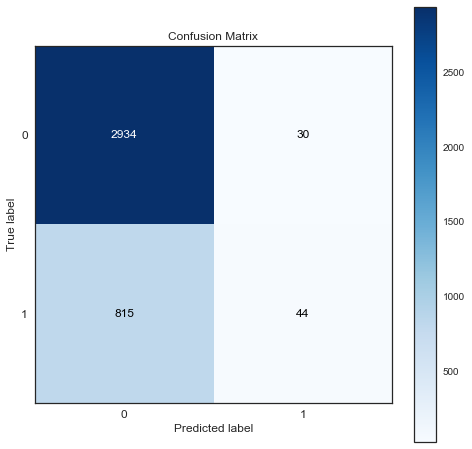

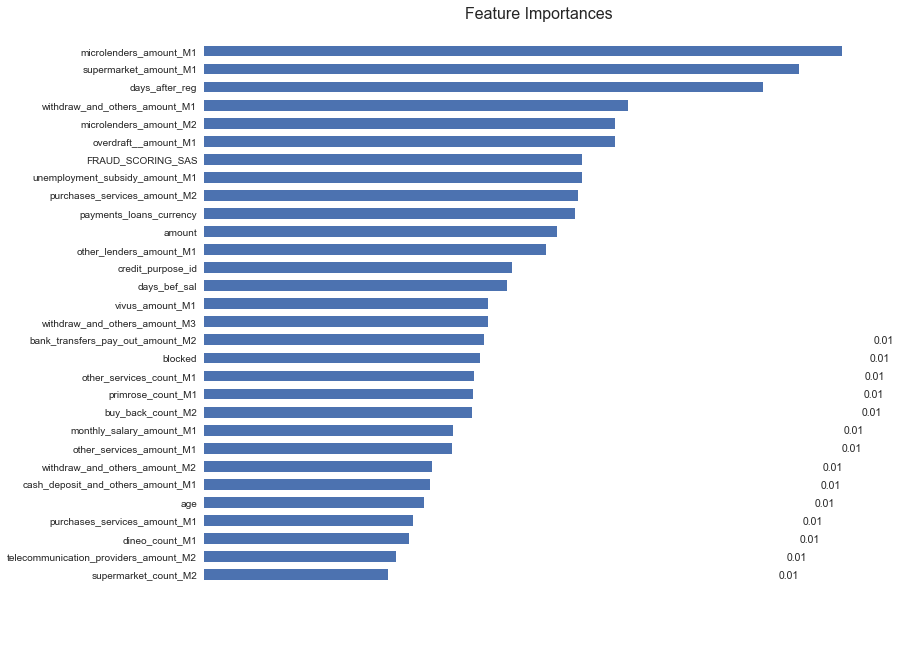

In [346]:
#INST + APPDATA NPL30 with Fraud
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.5)

ROC_AUC:   0.6884478751948632
Gini:      0.37689575038972634
F1_score:  0.15559440559440557
Log_loss:  7.196975503616982


Classification_report: 
              precision    recall  f1-score   support

          0       0.98      0.80      0.88      4482
          1       0.09      0.58      0.16       154

avg / total       0.95      0.79      0.86      4636



Weight,Feature
0.0422 ± 0.1899,microlenders_amount_M1
0.0333 ± 0.1606,days_after_reg
0.0274 ± 0.1348,withdraw_and_others_amount_M1
0.0245 ± 0.1655,amount
0.0226 ± 0.1358,age
0.0176 ± 0.1202,cash_deposit_and_others_amount_M1
0.0156 ± 0.1071,payments_loans_currency
0.0156 ± 0.1098,supermarket_amount_M1
0.0146 ± 0.1049,withdraw_and_others_count_M2
0.0143 ± 0.1093,purchases_services_amount_M3


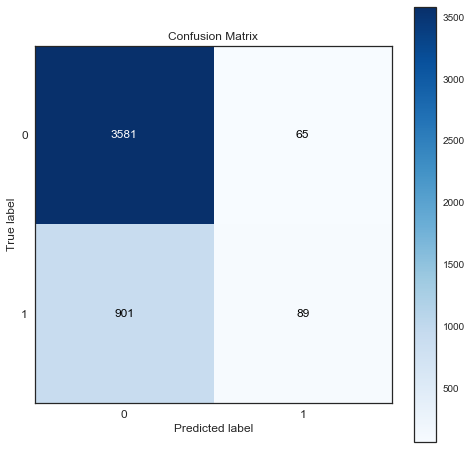

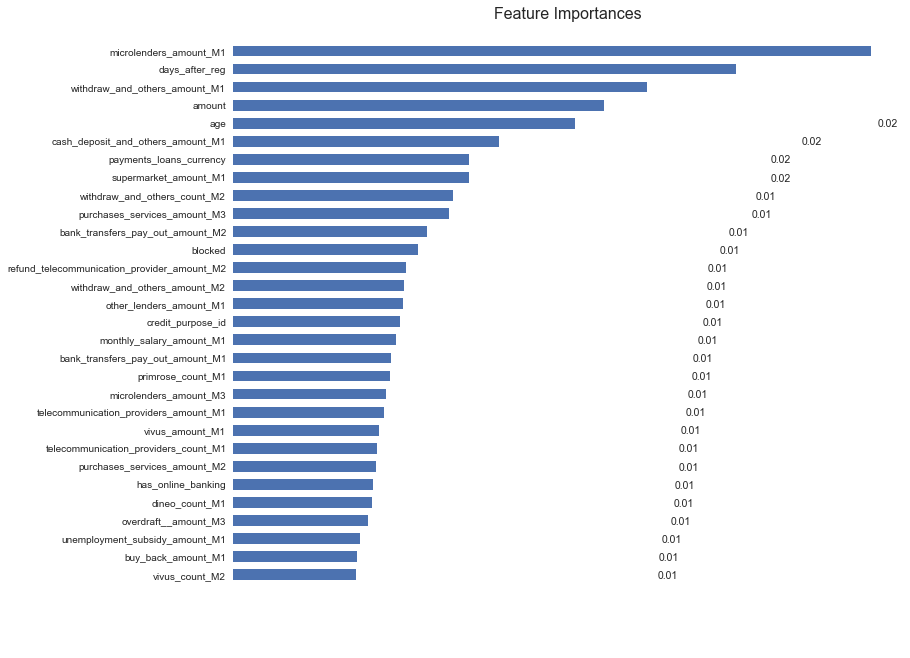

In [39]:
#INST + APPDATA NPL30
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.5)

ROC_AUC:   0.6811762536873156
Gini:      0.3623525073746312
F1_score:  0.1959885386819484
Log_loss:  8.488164996172221


Classification_report: 
              precision    recall  f1-score   support

          0       0.97      0.76      0.85      5424
          1       0.12      0.60      0.20       285

avg / total       0.93      0.75      0.82      5709



Weight,Feature
0.0421 ± 0.1953,microlenders_amount_M1
0.0373 ± 0.1600,withdraw_and_others_amount_M1
0.0355 ± 0.1482,days_after_reg
0.0223 ± 0.1140,age
0.0191 ± 0.1184,supermarket_amount_M1
0.0167 ± 0.0953,payments_loans_currency
0.0161 ± 0.0971,bank_transfers_pay_out_amount_M1
0.0157 ± 0.1206,other_lenders_amount_M2
0.0153 ± 0.1066,refund_telecommunication_provider_amount_M1
0.0145 ± 0.0984,purchases_services_amount_M2


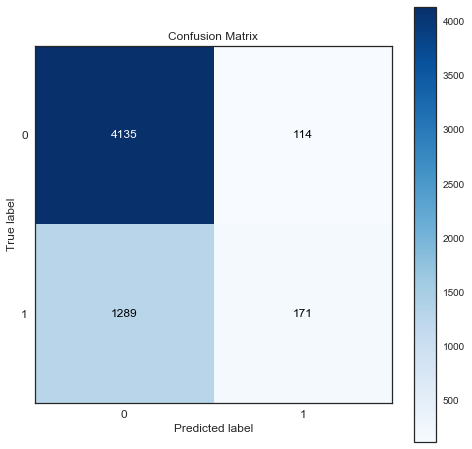

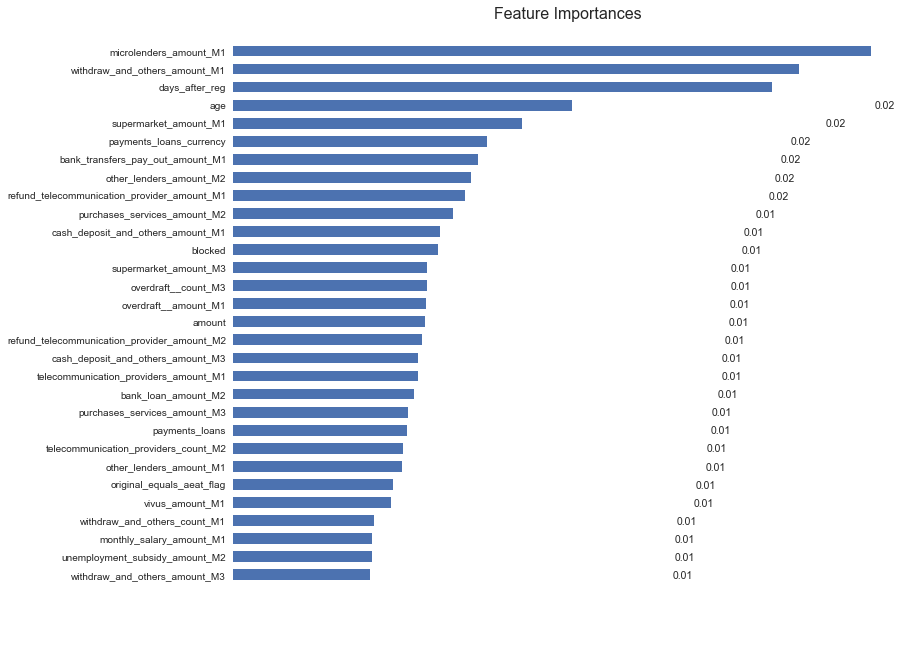

In [28]:
#INST + APPDATA NPL30
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.5)

# For Cancelled results

In [347]:
%%time
df = pd.read_sql('''
SELECT
    c.date_requested,
    day(c.date_requested)                                                                               AS day_date_req,
    c.id                                                                                                AS credit_id,
    (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15,
    round(datediff(c.date_requested, pd.birthday) / 365)                                                AS age,
    pd.dependants_count,
    pd.maritalStatus_old,
    pd.maritalStatus,
    pd.sex,
    pd.habitation_old,
    pd.habitation,
    pd.payments_loans,
    pd.payments_loans_currency,
    pd.credit_purpose_id,
    a.city,
    if(ua.blocked IS TRUE, 1, 0)                                                                        AS blocked,
    if(ua.change_password_on_login IS TRUE, 1,0)                                                        AS change_password_on_login,
    if(ua.deleted IS TRUE, 1, 0)                                                                        AS deleted,
    datediff(c.date_requested, ua.creation_date)                                                        AS days_after_reg,

    w.amount,
    w.education,
    w.job_time,
    ifnull(abs(datediff(w.next_income_date, c.date_requested)), -1)                                     AS days_bef_sal,
    ifnull(abs((day(w.next_income_date) - day(c.date_requested))), -1)                                  AS days_bef_sal_days,
    w.employment_id,
    w.industry_id,

    if(b.is_filled_idv IS TRUE, 1, 0)                                                                                               AS is_filled_idv,
    if(b.is_reset_bank_account IS TRUE, 1, 0)                                                                                        AS is_reset_bank_account,
    if(b.has_online_banking IS TRUE, 1, 0)                                                                                            AS has_online_banking,
    #iud.*,
    ineg.*,
    ipos.*,
    inm.*,
    ipm.*,
    fs.FRAUD_SCORING_SAS,
    if(d.registered_flag IS TRUE, 1, 0)                                                                                               AS registered_flag,
    if(d.original_equals_aeat_flag IS TRUE, 1, 0)                                                                                     AS original_equals_aeat_flag
FROM moneyman_es.credit c
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.personal_data pd
        ON b.personal_data_id = pd.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.address a
        ON b.address_id = a.id
    LEFT JOIN moneyman_es.user_account ua
        ON b.user_account_id = ua.id
    LEFT JOIN moneyman_es.credit_risk_filter crf
        ON c.id = crf.credit_id
    left join moneyman_es.instantor_agg_negative_total ineg
on ineg.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_total ipos
on ipos.credit_id=crf.credit_id

#left join moneyman_es.instantor_user_details iud
#on iud.id=crf.instantor_user_details_id

left join moneyman_es.instantor_agg_negative_microlenders inm
on inm.credit_id=crf.credit_id

left join moneyman_es.instantor_agg_positive_microlenders ipm
on ipm.credit_id=crf.credit_id 
left join rnd.fs_new_inst_res fs
    on fs.id=c.id
LEFT JOIN moneyman_es.deyde_passport_response d
        ON c.id = d.credit_id
WHERE crf.instantor_user_details_id is not null 
    #c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED')
    AND credit_number = 1 AND
   c.date_requested >= '2018-01-01' and c.date_requested < '2018-03-01' 
    #and c.finance_type = 'PERIODIC';
''', con=con())
df.fillna(-1, inplace=True)
#df.balance = df.balance.map(lambda x: float(x))
#df.device_new = df.device_new.map(lambda x: float(x))
df1 = df.copy()

Wall time: 16.4 s


In [348]:
df.drop(['date_requested', 'id', #'email', 'phone', 'address', 'user_name', 'instantor_id', 'borrower_id','national_id', 
         'instantor_user_details_id',  'number', 'kind', 'currency', 'iban', 'account_number', 'holder_name','credit_request_id' 
         ], axis=1, inplace=True)

In [349]:
cat_vars = ['habitation', 'habitation_old', 'maritalStatus', 'city']
for i in cat_vars:
    df[i] = label.fit_transform(df[i].astype(str))

In [350]:
df['Score'] = gs.best_estimator_.predict_proba(df.drop(['NPL15','credit_id'], axis=1))[:,1]

In [351]:
writer = pd.ExcelWriter('INST_EARLY_WITH_FRAUD_V4.xlsx')
df[['credit_id','Score']].to_excel(writer,'INST_EARLY', index=False)
writer.save()

# Only Appdata

In [361]:
%%time
df = pd.read_sql('''
SELECT
    c.date_requested,
    day(c.date_requested)                                                                               AS day_date_req,
    c.id                                                                                                AS credit_id,
  (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15,
    round(datediff(c.date_requested, pd.birthday) / 365)                                                AS age,
    pd.dependants_count,
    pd.maritalStatus_old,
    pd.maritalStatus,
    pd.sex,
    pd.habitation_old,
    pd.habitation,
    pd.payments_loans,
    pd.payments_loans_currency,
    pd.credit_purpose_id,
    a.city,a.number,
    if(ua.blocked IS TRUE, 1, 0)                                                                        AS blocked,
    if(ua.change_password_on_login IS TRUE, 1,0)                                                        AS change_password_on_login,
    if(ua.deleted IS TRUE, 1, 0)                                                                        AS deleted,
    datediff(c.date_requested, ua.creation_date)                                                         AS days_after_reg,

    w.amount,
    w.education,
    w.job_time,
    ifnull(abs(datediff(w.next_income_date, c.date_requested)), -1)                                     AS days_bef_sal,
    ifnull(abs((day(w.next_income_date) - day(c.date_requested))), -1)                                  AS days_bef_sal_days,
    w.employment_id,
    w.industry_id,

    abs(datediff(io.device_firstseen,c.date_requested))                                                 AS device_seen_date,
    io.result,
    io.reason,
    io.device_new,
    io.device_type,
    io.device_js_enabled,
    io.device_flash_enabled,
    io.device_flash_installed,
    io.device_browser_type,
    io.ipaddress_loc_city,
    io.ipaddress_loc_country,
    io.ipaddressLoc_region,
    io.realipaddress_loc_city,
    io.realipaddress_loc_country,
    io.realipaddress_loc_region,
    io.ruleset_rulesmatched,
    io.ruleset_score,

    if(b.is_filled_idv IS TRUE, 1, 0)                                                                                               AS is_filled_idv,
    if(b.is_reset_bank_account IS TRUE, 1, 0)                                                                                        AS is_reset_bank_account,
    if(b.has_online_banking IS TRUE, 1, 0)                                                                                            AS has_online_banking,
    
    if(d.registered_flag IS TRUE, 1, 0)                                                                                               AS registered_flag,
    if(d.original_equals_aeat_flag IS TRUE, 1, 0)                                                                                     AS original_equals_aeat_flag,
    if(d.original_modified_flag IS TRUE, 1, 0)                                                                                        AS original_modified_flag,
fs.FRAUD_SCORING_SAS,
did.segxxx as deyde_demographic_profile 
,did.msegxx as deyde_economic_segment
FROM moneyman_es.credit c
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.personal_data pd
        ON b.personal_data_id = pd.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.address a
        ON b.address_id = a.id
    LEFT JOIN moneyman_es.user_account ua
        ON b.user_account_id = ua.id
    LEFT JOIN moneyman_es.iovation io
        ON c.id = io.credit_id
    LEFT JOIN moneyman_es.credit_risk_filter crf
        ON c.id = crf.credit_id
    left join rnd.fs_new_inst_res fs
        on fs.id=c.id
LEFT JOIN moneyman_es.deyde_passport_response d
        ON c.id = d.credit_id
     left join moneyman_es.deyede_integration_data did
  on did.id = crf.deyede_integration_data_id
WHERE crf.instantor_user_details_id is null and
    c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED') AND credit_number = 1 AND c.date_requested > '2017-06-01' AND
    c.date_requested < '2018-01-01'
''', con=con())
df.fillna(-1, inplace=True)
#df.balance = df.balance.map(lambda x: float(x))
df.device_new = df.device_new.map(lambda x: float(x))
df1 = df.copy()

Wall time: 1.21 s


In [362]:
#df.dtypes[df.dtypes==object]

In [363]:
df.NPL15.value_counts()

0    3351
1    2189
Name: NPL15, dtype: int64

In [364]:
df.drop(['date_requested',  'credit_id' #'id', 'instantor_user_details_id','email', 'phone', 'address', 'user_name', 
         #'instantor_id', 'borrower_id','national_id', 
         #'number', 'kind', 'currency', 'iban', 'account_number', 'holder_name','credit_request_id' 
         ], axis=1, inplace=True)

In [365]:
cat_vars = ['habitation', 'habitation_old', 'maritalStatus', 'city', 'result', 'reason','device_type','device_browser_type',
           'ipaddress_loc_city', 'ipaddress_loc_country', 'ipaddressLoc_region','realipaddress_loc_city',
           'realipaddress_loc_country', 'realipaddress_loc_region', 'deyde_demographic_profile'
           ]
for i in cat_vars:
    df[i] = label.fit_transform(df[i].astype(str))
    joblib.dump(label, 'ES_INST_%s.pkl'% i)

In [366]:
y = df.NPL15
X = df.drop(['NPL15'], axis=1)

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [368]:
clf = GradientBoostingClassifier(random_state=1)

In [369]:
%%time
tuned_parameters = {'n_estimators': [100,120],
                    'max_depth': [3,5]
                    }                    #'learning_rate': [0.1, 0.01] 
gs = GridSearchCV(clf, tuned_parameters, cv=5, verbose=2).fit(X_train, y_train)
print (gs.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .......................... max_depth=3, n_estimators=100 -   0.3s
[CV] max_depth=3, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................... max_depth=3, n_estimators=100 -   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .......................... max_depth=3, n_estimators=100 -   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .......................... max_depth=3, n_estimators=100 -   0.3s
[CV] max_depth=3, n_estimators=100 ...................................
[CV] .......................... max_depth=3, n_estimators=100 -   0.3s
[CV] max_depth=3, n_estimators=120 ...................................
[CV] .......................... max_depth=3, n_estimators=120 -   0.4s
[CV] max_depth=3, n_estimators=120 ...................................
[CV] .......................... max_depth=3, n_estimators=120 -   0.4s
[CV] max_depth=3, n_estimators=120 ...................................
[CV] .......................... max_depth=3, n_estimators=120 -   0.4s
[CV] max_depth=3, n_estimators=120 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   14.9s finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)
Wall time: 15.5 s


ROC_AUC:   0.6706122364134711
Gini:      0.34122447282694224
F1_score:  0.5313001605136436
Log_loss:  11.028413587747204


Classification_report: 
              precision    recall  f1-score   support

          0       0.84      0.69      0.76      1318
          1       0.45      0.65      0.53       511

avg / total       0.73      0.68      0.69      1829



Weight,Feature
0.1464 ± 0.3432,amount
0.0828 ± 0.3433,has_online_banking
0.0818 ± 0.2007,age
0.0632 ± 0.2809,deyde_economic_segment
0.0565 ± 0.1813,payments_loans
0.0525 ± 0.2005,device_seen_date
0.0482 ± 0.1949,days_bef_sal
0.0418 ± 0.1777,habitation
0.0389 ± 0.1874,realipaddress_loc_city
0.0343 ± 0.1739,day_date_req


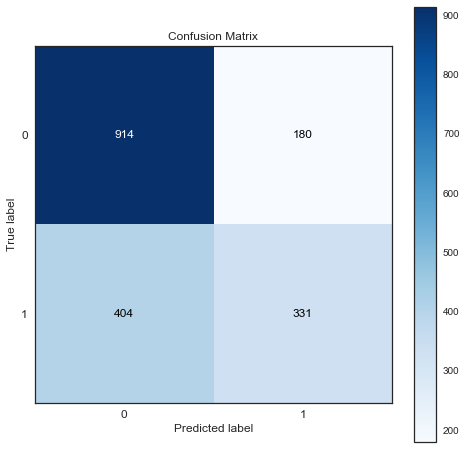

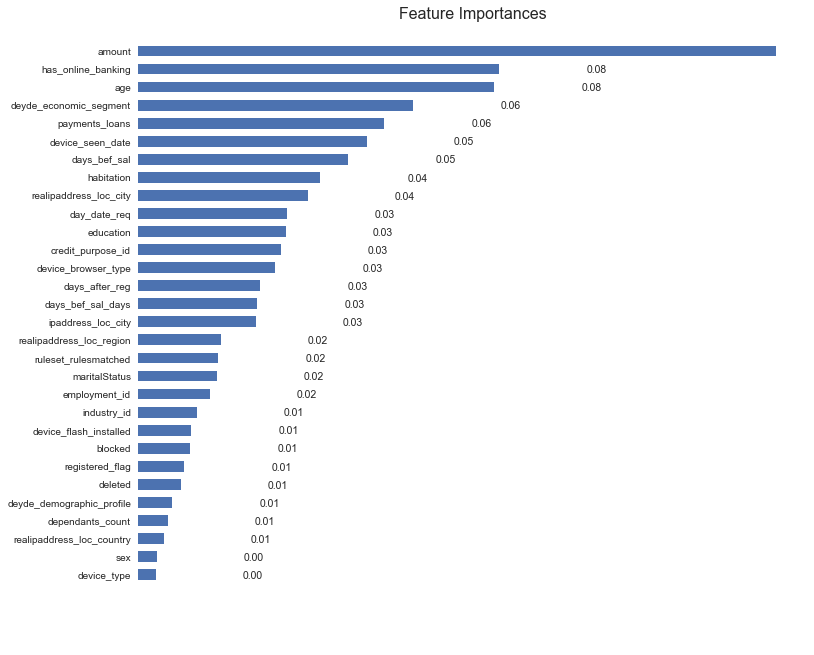

In [370]:
#APPDATA NPL30
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.5)

ROC_AUC:   0.6706122364134711
Gini:      0.34122447282694224
F1_score:  0.5313001605136436
Log_loss:  11.028413587747204


Classification_report: 
              precision    recall  f1-score   support

          0       0.84      0.69      0.76      1318
          1       0.45      0.65      0.53       511

avg / total       0.73      0.68      0.69      1829



Weight,Feature
0.1455 ± 0.3442,amount
0.0827 ± 0.3434,has_online_banking
0.0807 ± 0.2051,age
0.0632 ± 0.2809,deyde_economic_segment
0.0565 ± 0.1813,payments_loans
0.0526 ± 0.2004,device_seen_date
0.0485 ± 0.1973,days_bef_sal
0.0429 ± 0.1780,habitation
0.0351 ± 0.1845,realipaddress_loc_city
0.0341 ± 0.1791,day_date_req


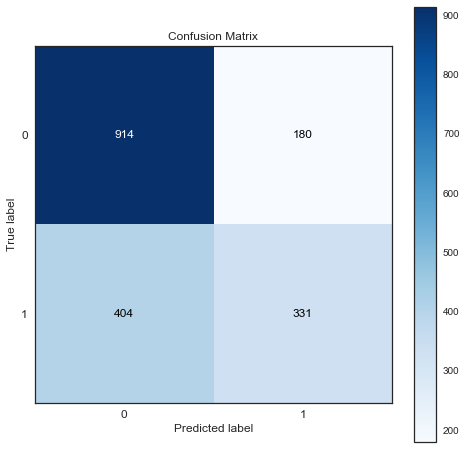

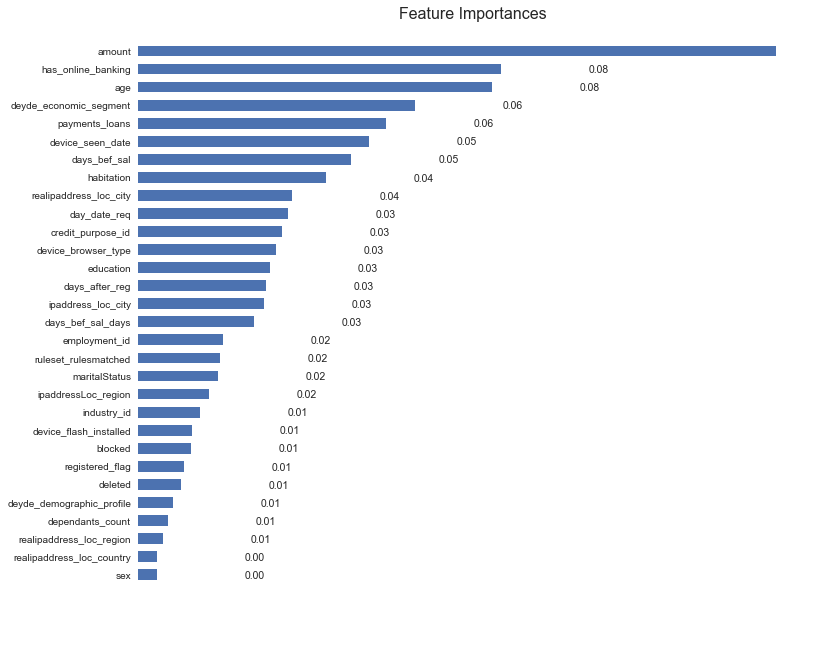

In [289]:
#APPDATA NPL30 GINI 34
IDF.plot_score(gs.best_estimator_, X_test, y_test, cut_off=0.5)

# REJECTED APPDATA

In [292]:
%%time
df = pd.read_sql('''
SELECT
    c.date_requested,
    day(c.date_requested)                                                                               AS day_date_req,
    c.id                                                                                                AS credit_id,
  (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15,
    round(datediff(c.date_requested, pd.birthday) / 365)                                                AS age,
    pd.dependants_count,
    pd.maritalStatus_old,
    pd.maritalStatus,
    pd.sex,
    pd.habitation_old,
    pd.habitation,
    pd.payments_loans,
    pd.payments_loans_currency,
    pd.credit_purpose_id,
    a.city,a.number,
    if(ua.blocked IS TRUE, 1, 0)                                                                        AS blocked,
    if(ua.change_password_on_login IS TRUE, 1,0)                                                        AS change_password_on_login,
    if(ua.deleted IS TRUE, 1, 0)                                                                        AS deleted,
    datediff(c.date_requested, ua.creation_date)                                                         AS days_after_reg,

    w.amount,
    w.education,
    w.job_time,
    ifnull(abs(datediff(w.next_income_date, c.date_requested)), -1)                                     AS days_bef_sal,
    ifnull(abs((day(w.next_income_date) - day(c.date_requested))), -1)                                  AS days_bef_sal_days,
    w.employment_id,
    w.industry_id,

    abs(datediff(io.device_firstseen,c.date_requested))                                                 AS device_seen_date,
    io.result,
    io.reason,
    io.device_new,
    io.device_type,
    io.device_js_enabled,
    io.device_flash_enabled,
    io.device_flash_installed,
    io.device_browser_type,
    io.ipaddress_loc_city,
    io.ipaddress_loc_country,
    io.ipaddressLoc_region,
    io.realipaddress_loc_city,
    io.realipaddress_loc_country,
    io.realipaddress_loc_region,
    io.ruleset_rulesmatched,
    io.ruleset_score,

    if(b.is_filled_idv IS TRUE, 1, 0)                                                                                               AS is_filled_idv,
    if(b.is_reset_bank_account IS TRUE, 1, 0)                                                                                        AS is_reset_bank_account,
    if(b.has_online_banking IS TRUE, 1, 0)                                                                                            AS has_online_banking,
    
    if(d.registered_flag IS TRUE, 1, 0)                                                                                               AS registered_flag,
    if(d.original_equals_aeat_flag IS TRUE, 1, 0)                                                                                     AS original_equals_aeat_flag,
    if(d.original_modified_flag IS TRUE, 1, 0)                                                                                        AS original_modified_flag,
did.segxxx as deyde_demographic_profile 
    ,did.msegxx as deyde_economic_segment
FROM moneyman_es.credit c
    LEFT JOIN moneyman_es.borrower b
        ON c.borrower_id = b.id
    LEFT JOIN moneyman_es.personal_data pd
        ON b.personal_data_id = pd.id
    LEFT JOIN moneyman_es.work w
        ON b.work_id = w.id
    LEFT JOIN moneyman_es.address a
        ON b.address_id = a.id
    LEFT JOIN moneyman_es.user_account ua
        ON b.user_account_id = ua.id
    LEFT JOIN moneyman_es.iovation io
        ON c.id = io.credit_id
    LEFT JOIN moneyman_es.credit_risk_filter crf
        ON c.id = crf.credit_id
LEFT JOIN moneyman_es.deyde_passport_response d
        ON c.id = d.credit_id
     left join moneyman_es.deyede_integration_data did
  on did.id = crf.deyede_integration_data_id
WHERE crf.instantor_user_details_id is null 
    #c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED') 
    AND credit_number = 1  AND
    c.date_requested >= '2018-01-01' AND c.date_requested < '2018-03-01'
''', con=con())
df.fillna(-1, inplace=True)
#df.balance = df.balance.map(lambda x: float(x))
df.device_new = df.device_new.map(lambda x: float(x))
df1 = df.copy()

Wall time: 1.88 s


In [293]:
df.drop(['date_requested',  #'id', 'instantor_user_details_id','email', 'phone', 'address', 'user_name', 'instantor_id', 'borrower_id','national_id', 
          # 'number', 'kind', 'currency', 'iban', 'account_number', 'holder_name','credit_request_id' 
         ], axis=1, inplace=True)

In [294]:
cat_vars = ['habitation', 'habitation_old', 'maritalStatus', 'city', 'result', 'reason','device_type','device_browser_type',
           'ipaddress_loc_city', 'ipaddress_loc_country', 'ipaddressLoc_region','realipaddress_loc_city',
          'realipaddress_loc_country', 'realipaddress_loc_region',
            'deyde_demographic_profile'
           ]
for i in cat_vars:
    label = joblib.load('ES_INST_%s.pkl'% i)
    df[i] = label.fit_transform(df[i].astype(str))

In [295]:
df['Score'] = gs.best_estimator_.predict_proba(df.drop(['NPL15','credit_id'], axis=1))[:,1]

In [296]:
writer = pd.ExcelWriter('INST_EARLY_APPDATA_V1.xlsx')
df[['credit_id','Score']].to_excel(writer,'INST_EARLY', index=False)
writer.save()

# Other BEHAVIOUR

In [ ]:
pca = PCA(n_components=150)
clf = GradientBoostingClassifier(random_state=1)
pipe = Pipeline(steps=[('pca', pca), ('clf', clf)])
tuned_parameters = {'clf__n_estimators': [100,120],
                    'clf__max_depth': [3,5]
                    }                    #'learning_rate': [0.1, 0.01] 
gs = GridSearchCV(pipe, tuned_parameters, cv=3, verbose=2).fit(X_train, y_train)

In [3]:
%%time
df = pd.read_sql('''
SELECT beh.*,
  (SELECT IF(((sum(`credit_payment`.`amount`) > 0) OR
                (CURDATE() < (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY))), 0,
               1)
     FROM moneyman_es.`credit_payment`
     WHERE ((`credit_payment`.`credit_id` = `c`.`id`)
            AND (`credit_payment`.`payment_date` <
                 (c.date_received + INTERVAL (least(c.credit_count_days, 31)) DAY + INTERVAL 31 DAY)))) AS NPL15
from moneyman_es.scoring_user_behaviour_params beh
    left join moneyman_es.credit c
    on c.id=beh.creditId
WHERE FIRSTNAME_profileChanged is not null and
    c.status IN ('ACTIVE', 'COMPLETED', 'EXPIRED') 
    AND credit_number = 1  AND
    c.date_requested >= '2017-07-01' AND c.date_requested < '2018-03-01'
''', con=con())
df.fillna(-1, inplace=True)
#df.balance = df.balance.map(lambda x: float(x))
df1 = df.copy()

Wall time: 4.59 s


In [4]:
for i in df.columns:
    if i.find('value')!=-1:
        df.drop(i, axis=1, inplace=True)
for i in df.columns:
    if i.find('VALUE')!=-1:
        df.drop(i, axis=1, inplace=True)
for i in df.columns:
    if i.find('Changed')!=-1 or i.find('changed')!=-1 or i.find('IsUp')!=-1:
        df[i] = label.fit_transform(df[i].astype(str))

In [400]:
df.dtypes[df.dtypes==object]

FIRSTNAME_profileChanged                       object
FIRSTNAME_jumpsCount                           object
FIRSTNAME_timeSpentInSec                       object
FIRSTLASTNAME_profileChanged                   object
FIRSTLASTNAME_jumpsCount                       object
FIRSTLASTNAME_timeSpentInSec                   object
SECONDLASTNAME_profileChanged                  object
SECONDLASTNAME_jumpsCount                      object
SECONDLASTNAME_timeSpentInSec                  object
BIRTHDAY_profileChanged                        object
BIRTHDAY_jumpsCount                            object
BIRTHDAY_timeSpentInSec                        object
PASSPORTIDENTIFICATIONNUMBER_profileChanged    object
PASSPORTIDENTIFICATIONNUMBER_jumpsCount        object
PASSPORTIDENTIFICATIONNUMBER_timeSpentInSec    object
PHONE_profileChanged                           object
PHONE_jumpsCount                               object
PHONE_timeSpentInSec                           object
EMAIL_profileChanged        

In [388]:
df.ix[:,30:40]

,EMAIL_timeSpentInSec,EMAIL_value,ACTLOCALITY_profileChanged,ACTLOCALITY_jumpsCount,ACTLOCALITY_timeSpentInSec,ACTLOCALITY_value,ACTSTREET_profileChanged,ACTSTREET_jumpsCount,ACTSTREET_timeSpentInSec,ACTSTREET_value
0,24,Juanmamorales74@gmail.com,false,2,21,Atarfe,false,2,10,Calle Mejorana
1,139,"franciscojavier1983villa@hotmail.com,leonormar...",false,1,11,Collado villalba,false,1,12,Calle trinidad
2,20,citro.jtbs@gmail.com,false,2,77,ciudad real,false,2,56,Elisa Cendrero
3,3,rubiorut49@gmail.com,false,1,5,Badalona,false,4,7,Sant Gregori
4,10,fieradelacasa@hotmail.com,false,2,7,cartagena,false,4,11,"c/ruperto chapi,ruperto chapi"
5,28,miguelvillamiana@hotmail.com,false,2,18,Oviedo,false,2,10,Villamiana
6,2,aixaritavic@gmail.com,-1,-1,-1,-1,-1,-1,-1,-1
7,14,albertovgar@hotmail.com,false,2,20,Madrid,false,2,18,Argumosa
8,77,"charo505@thomail.es,charo505@thomail.con,javi....",false,2,15,Malaga,false,2,7,Calle Emilio prados
9,5,noemiguelbarres@hotmail.com,-1,-1,-1,-1,-1,-1,-1,-1


In [5]:
df.drop(['request_date',  'creditId', 'id', 'borrowerId',  'Operating_system',
       'Operating_system_version', 'Device_Type', 'Device_Model',
       'Device_Language', 'IP', 'Geographical_location', 'Settings',
         ], axis=1, inplace=True)

In [ ]:
cat_vars = ['FIRSTLASTNAME_profileChanged', 'FIRSTNAME_profileChanged', 'SECONDLASTNAME_profileChanged', 
            'BIRTHDAY_profileChanged', 'PASSPORTIDENTIFICATIONNUMBER_profileChanged', 'PHONE_profileChanged',
            
            'PHONE_value','ACTLOCALITY_profileChanged',
           'ipaddress_loc_city', 'ipaddress_loc_country', 'ipaddressLoc_region','realipaddress_loc_city',
           'realipaddress_loc_country', 'realipaddress_loc_region', 'deyde_demographic_profile'
           ]
for i in cat_vars:
    df[i] = label.fit_transform(df[i].astype(str))
    joblib.dump(label, 'ES_INST_%s.pkl'% i)

In [10]:
from sklearn import manifold
from sklearn.decomposition import PCA
from ggplot import *
tsne = manifold.TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
pca = PCA(n_components=2)
X = df.drop('NPL15',axis=1)

In [30]:
%%time
df_new = tsne.fit_transform(X)

Wall time: 20min 13s


In [19]:
df_new = pca.fit_transform(X)

In [23]:
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = df_new[:,0]
df_tsne['y-tsne'] = df_new[:,1]

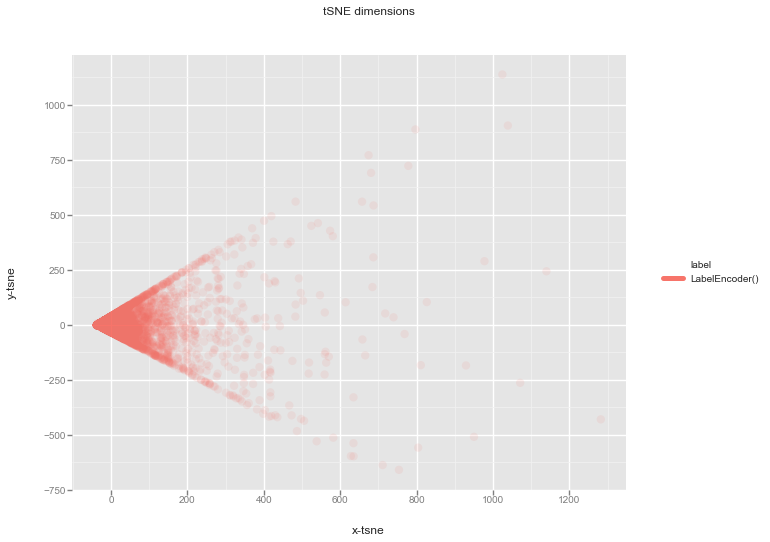

<ggplot: (176949244480)>

In [29]:
chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions")
chart